In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import time
from database import DatabaseManager 
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

BASE_URL = "https://www.senscritique.com"
LIST_URL = "https://www.senscritique.com/liste/les_250_films_a_voir_imdb_top_250/251213"

headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36",
}

def parse_duration(dur):
    if not dur: return None
    return dur.replace("PT", "").replace("H", "h ").replace("M", "min")

# On initialise la base de données
db = DatabaseManager("base_de_données.db")

for page in range(1, 7):
    print(f"Scraping page {page}...")
    url = LIST_URL if page == 1 else f"{LIST_URL}?page={page}"
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        continue
        
    soup = BeautifulSoup(response.text, "html.parser")

    #On cherche tous les liens de films sur la page
    film_links = soup.find_all("a", class_="sc-f84047c3-0 sc-d9336e28-1 bZInWI gfTNTa sc-d947697b-1 deogiZ sc-b5c2c6dc-3 dikXUs")

    for f in film_links:
        try:
            link = BASE_URL + f["href"]
            soup_film = BeautifulSoup(requests.get(link, headers=headers).text, "html.parser")

            # on extrait les données grace à JSON
            json_tag = soup_film.find("script", type="application/ld+json")
            if not json_tag: continue
            
            data = json.loads(json_tag.text)

            # On classe les données
            title = data.get("name")
            year = int(data.get("datePublished", "0000")[:4])
            genre = ", ".join(data["genre"]) if isinstance(data.get("genre"), list) else data.get("genre")
            duration = parse_duration(data.get("duration"))

            director_data = data.get("director", [])
            if isinstance(director_data, dict):
                director = director_data.get("name")
            else:
                director = ", ".join([d.get("name", "") for d in director_data])

            rating_data = data.get("aggregateRating", {})
            imdb_rating = float(rating_data.get("ratingValue", 0))
            rating_count = int(rating_data.get("ratingCount", 0))

            # On envoie tout à la base de données
            db.insert_film(title, year, genre, duration, director, imdb_rating, rating_count, link)
            
            print(f"Ajouté : {title}")


        except Exception as e:#on se protège des erreurs
            print(f"Erreur sur un film : {e}")
            continue

db.close()
print("Scraping terminé et base de données enregistrée.")

#On transforme la base de données en dataframe

conn = sqlite3.connect("base_de_données.db")

df = pd.read_sql_query("SELECT * FROM films", conn)

conn.close()
print(df.head())

Scraping page 1...
Ajouté : Les Évadés
Ajouté : Le Parrain
Ajouté : Le Parrain - 2e Partie
Ajouté : Pulp Fiction
Ajouté : Le Bon, la Brute et le Truand
Ajouté : The Dark Knight - Le Chevalier noir
Ajouté : Douze Hommes en colère
Ajouté : La Liste de Schindler
Ajouté : Le Seigneur des anneaux - Le Retour du roi
Ajouté : Fight Club
Ajouté : L'Empire contre-attaque
Ajouté : Le Seigneur des anneaux - La Communauté de l'anneau
Ajouté : Vol au-dessus d'un nid de coucou
Ajouté : Inception
Ajouté : Les Affranchis
Ajouté : La Guerre des étoiles
Ajouté : Les Sept Samouraïs
Ajouté : Forrest Gump
Ajouté : Matrix
Ajouté : Le Seigneur des anneaux - Les Deux Tours
Ajouté : La Cité de Dieu
Ajouté : Seven
Ajouté : Le Silence des agneaux
Ajouté : Il était une fois dans l'Ouest
Ajouté : Casablanca
Ajouté : Usual Suspects
Ajouté : Les Aventuriers de l'arche perdue
Ajouté : Fenêtre sur cour
Ajouté : La vie est belle
Ajouté : Psychose
Scraping page 2...
Ajouté : Léon
Ajouté : Boulevard du crépuscule
Ajouté 

In [71]:
df.head(10)

,id,title,year,genre,duration,director,rating,rating_count,link,budget,origine,date_scraping
0,1,Les Évadés,1994,Drame,2h 22min,Frank Darabont,8.1,65372,https://www.senscritique.com/film/les_evades/4...,None,None,2026-01-21T15:20:27.096767
1,2,Le Parrain,1972,"Policier, Drame",2h 55min,Francis Ford Coppola,8.5,75543,https://www.senscritique.com/film/le_parrain/4...,None,None,2026-01-21T15:20:27.347525
2,3,Le Parrain - 2e Partie,1974,"Gangster, Drame",3h 20min,Francis Ford Coppola,8.3,44596,https://www.senscritique.com/film/le_parrain_2...,None,None,2026-01-21T15:20:27.547934
3,4,Pulp Fiction,1994,"Gangster, Policier, Comédie",2h 34min,Quentin Tarantino,8.3,238205,https://www.senscritique.com/film/pulp_fiction...,None,None,2026-01-21T15:20:27.753848
4,5,"Le Bon, la Brute et le Truand",1966,"Western, Aventure",2h 59min,Sergio Leone,8.5,58684,https://www.senscritique.com/film/le_bon_la_br...,None,None,2026-01-21T15:20:27.948964
5,6,The Dark Knight - Le Chevalier noir,2008,"Action, Policier, Thriller",2h 32min,Christopher Nolan,8.0,131563,https://www.senscritique.com/film/the_dark_kni...,None,None,2026-01-21T15:20:28.146366
6,7,Douze Hommes en colère,1957,"Policier, Drame",1h 36min,Sidney Lumet,8.7,57627,https://www.senscritique.com/film/douze_hommes...,None,None,2026-01-21T15:20:28.347010
7,8,La Liste de Schindler,1993,"Biopic, Drame, Historique, Guerre",3h 15min,Steven Spielberg,8.1,63192,https://www.senscritique.com/film/la_liste_de_...,None,None,2026-01-21T15:20:28.567364
8,9,Le Seigneur des anneaux - Le Retour du roi,2003,"Aventure, Fantasy",3h 21min,Peter Jackson,8.1,117359,https://www.senscritique.com/film/le_seigneur_...,None,None,2026-01-21T15:20:28.760843
9,10,Fight Club,1999,"Drame, Thriller",2h 19min,David Fincher,8.1,257801,https://www.senscritique.com/film/fight_club/3...,None,None,2026-01-21T15:20:28.973983


In [72]:
df.drop(columns=['origine'], inplace=True)
df

,id,title,year,genre,duration,director,rating,rating_count,link,budget,date_scraping
0,1,Les Évadés,1994,Drame,2h 22min,Frank Darabont,8.1,65372,https://www.senscritique.com/film/les_evades/4...,None,2026-01-21T15:20:27.096767
1,2,Le Parrain,1972,"Policier, Drame",2h 55min,Francis Ford Coppola,8.5,75543,https://www.senscritique.com/film/le_parrain/4...,None,2026-01-21T15:20:27.347525
2,3,Le Parrain - 2e Partie,1974,"Gangster, Drame",3h 20min,Francis Ford Coppola,8.3,44596,https://www.senscritique.com/film/le_parrain_2...,None,2026-01-21T15:20:27.547934
3,4,Pulp Fiction,1994,"Gangster, Policier, Comédie",2h 34min,Quentin Tarantino,8.3,238205,https://www.senscritique.com/film/pulp_fiction...,None,2026-01-21T15:20:27.753848
4,5,"Le Bon, la Brute et le Truand",1966,"Western, Aventure",2h 59min,Sergio Leone,8.5,58684,https://www.senscritique.com/film/le_bon_la_br...,None,2026-01-21T15:20:27.948964
...,...,...,...,...,...,...,...,...,...,...,...
154,155,Dans ses yeux,2009,"Drame, Policier",2h 9min,Juan José Campanella,7.5,7137,https://www.senscritique.com/film/dans_ses_yeu...,None,2026-01-21T15:22:51.784002
155,156,Autant en emporte le vent,1939,"Drame, Historique, Romance, Guerre",3h 58min,Victor Fleming,7.1,14978,https://www.senscritique.com/film/autant_en_em...,None,2026-01-21T15:22:51.992064
156,157,Annie Hall,1977,"Romance, Comédie dramatique",1h 33min,Woody Allen,7.4,15883,https://www.senscritique.com/film/annie_hall/4...,None,2026-01-21T15:22:52.185072
157,158,Les Raisins de la colère,1940,"Drame, Historique, Road movie",2h 9min,John Ford,7.9,6379,https://www.senscritique.com/film/les_raisins_...,None,2026-01-21T15:22:52.391842


<Axes: xlabel='year'>

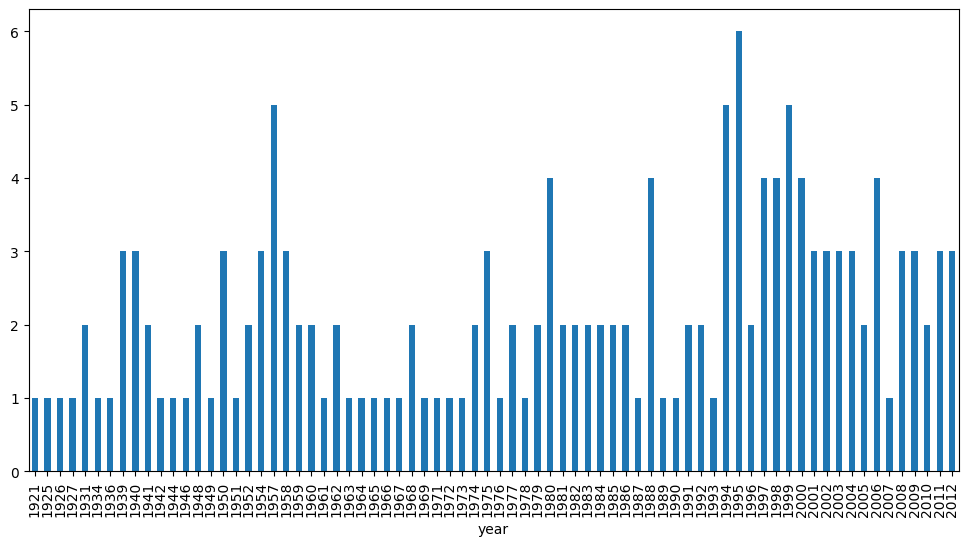

In [73]:
df['year'].value_counts().sort_index()
df['year'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))

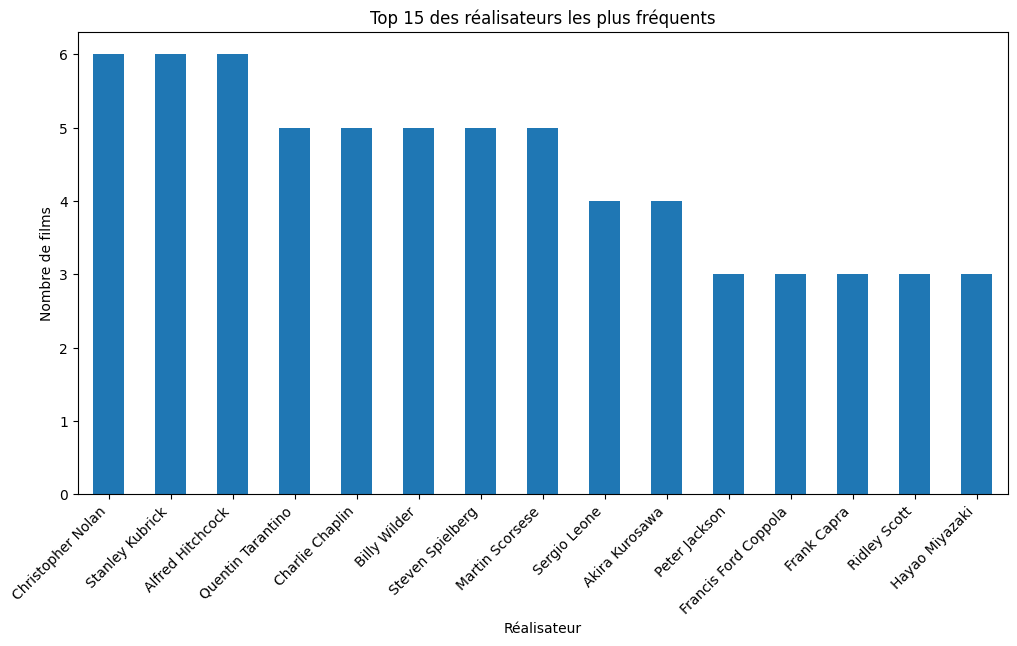

In [74]:
df['director'].value_counts().head(15).plot(kind='bar', figsize=(12, 6))
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 des réalisateurs les plus fréquents')
plt.xlabel('Réalisateur')
plt.ylabel('Nombre de films')
plt.xticks(rotation=45)
plt.show()

In [75]:
df[df['rating'] == df['rating'].max()]



,id,title,year,genre,duration,director,rating,rating_count,link,budget,date_scraping
6,7,Douze Hommes en colère,1957,"Policier, Drame",1h 36min,Sidney Lumet,8.7,57627,https://www.senscritique.com/film/douze_hommes...,None,2026-01-21T15:20:28.347010


In [76]:
df[df['rating'] == df['rating'].min()]

,id,title,year,genre,duration,director,rating,rating_count,link,budget,date_scraping
152,153,Avengers,2012,"Action, Aventure, Science-fiction, Fantastique",2h 23min,Joss Whedon,6.4,68727,https://www.senscritique.com/film/avengers/493660,None,2026-01-21T15:22:51.199539


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Douze Hommes en colère'),
  Text(1, 0, 'Le Bon, la Brute et le Truand'),
  Text(2, 0, 'Le Parrain'),
  Text(3, 0, "Il était une fois dans l'Ouest"),
  Text(4, 0, 'Les Sept Samouraïs'),
  Text(5, 0, 'Il était une fois en Amérique'),
  Text(6, 0, 'Le Voyage de Chihiro'),
  Text(7, 0, 'Princesse Mononoké'),
  Text(8, 0, "Vol au-dessus d'un nid de coucou"),
  Text(9, 0, "Voyage au bout de l'enfer")])

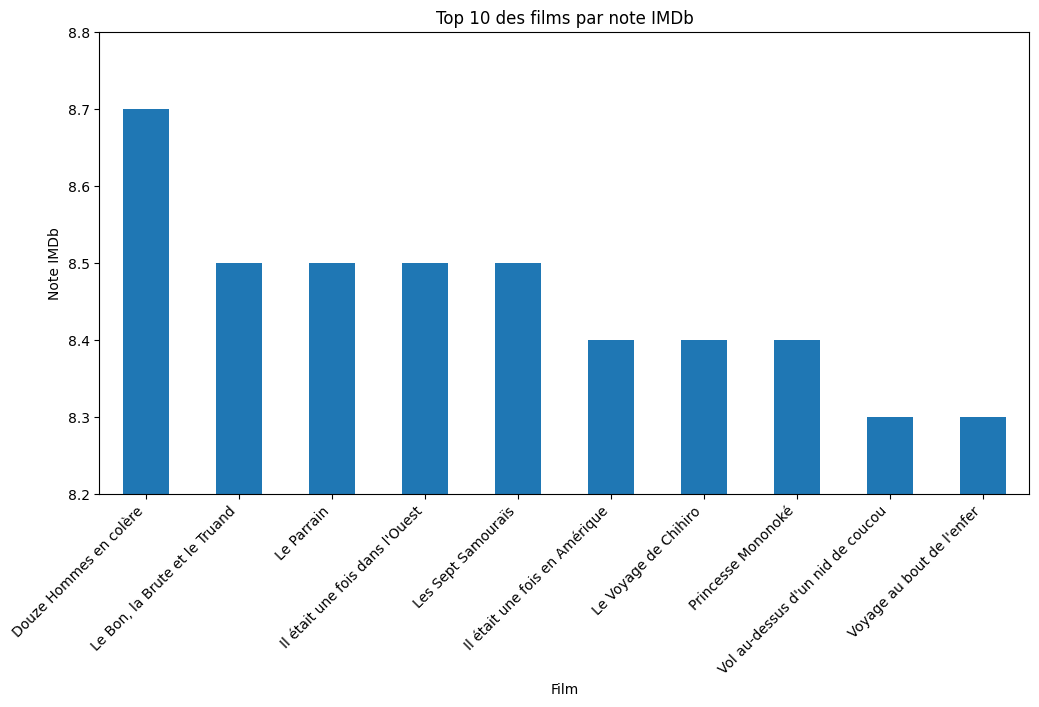

In [77]:
top10 = df.sort_values(by='rating', ascending=False).head(10)

gr = top10.plot(x='title',y='rating',kind='bar',figsize=(12, 6),legend=False)

gr.set_title('Top 10 des films par note IMDb')
gr.set_xlabel('Film')
gr.set_ylabel('Note IMDb')
gr.set_ylim(8.2, 8.8)
plt.xticks(rotation=45, ha='right')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Fight Club'),
  Text(1, 0, 'Pulp Fiction'),
  Text(2, 0, 'Inception'),
  Text(3, 0, 'Inglourious Basterds'),
  Text(4, 0, 'Forrest Gump'),
  Text(5, 0, 'Django Unchained'),
  Text(6, 0, "Le Seigneur des anneaux - La Communauté de l'anneau"),
  Text(7, 0, 'Matrix'),
  Text(8, 0, 'The Dark Knight - Le Chevalier noir'),
  Text(9, 0, 'Kill Bill - Volume 1')])

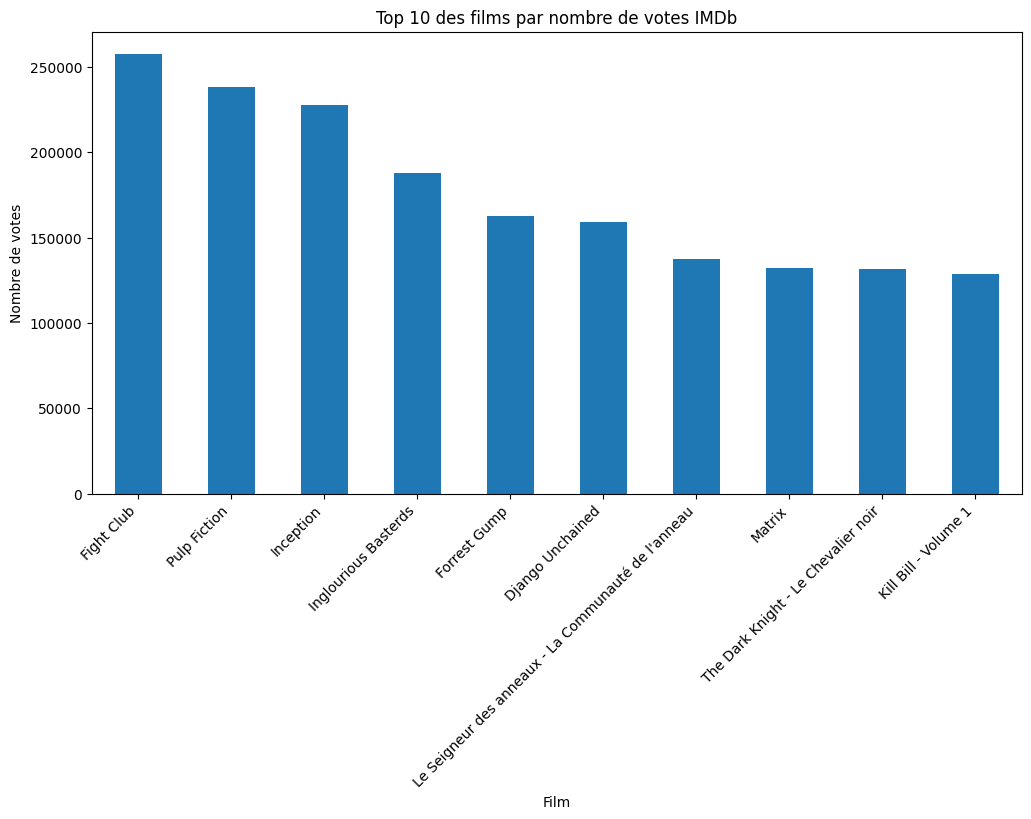

In [78]:
top10 = df.sort_values(by='rating_count', ascending=False).head(10)

gr = top10.plot(x='title',y='rating_count',kind='bar',figsize=(12, 6),legend=False)

gr.set_title('Top 10 des films par nombre de votes IMDb')
gr.set_xlabel('Film')
gr.set_ylabel('Nombre de votes')
plt.xticks(rotation=45, ha='right')

In [79]:
def durée(duration_str):
    hours = 0
    minutes = 0
    if 'h' in duration_str:
        parts = duration_str.split('h')
        hours = int(parts[0].strip())
        if 'min' in parts[1]:
            minutes_part = parts[1].split('min')
            minutes = int(minutes_part[0].strip())
    elif 'min' in duration_str:
        minutes_part = duration_str.split('min')
        minutes = int(minutes_part[0].strip())
    return hours * 60 + minutes

df['Durée'] = df['duration'].apply(durée)
df

,id,title,year,genre,duration,director,rating,rating_count,link,budget,date_scraping,Durée
0,1,Les Évadés,1994,Drame,2h 22min,Frank Darabont,8.1,65372,https://www.senscritique.com/film/les_evades/4...,None,2026-01-21T15:20:27.096767,142
1,2,Le Parrain,1972,"Policier, Drame",2h 55min,Francis Ford Coppola,8.5,75543,https://www.senscritique.com/film/le_parrain/4...,None,2026-01-21T15:20:27.347525,175
2,3,Le Parrain - 2e Partie,1974,"Gangster, Drame",3h 20min,Francis Ford Coppola,8.3,44596,https://www.senscritique.com/film/le_parrain_2...,None,2026-01-21T15:20:27.547934,200
3,4,Pulp Fiction,1994,"Gangster, Policier, Comédie",2h 34min,Quentin Tarantino,8.3,238205,https://www.senscritique.com/film/pulp_fiction...,None,2026-01-21T15:20:27.753848,154
4,5,"Le Bon, la Brute et le Truand",1966,"Western, Aventure",2h 59min,Sergio Leone,8.5,58684,https://www.senscritique.com/film/le_bon_la_br...,None,2026-01-21T15:20:27.948964,179
...,...,...,...,...,...,...,...,...,...,...,...,...
154,155,Dans ses yeux,2009,"Drame, Policier",2h 9min,Juan José Campanella,7.5,7137,https://www.senscritique.com/film/dans_ses_yeu...,None,2026-01-21T15:22:51.784002,129
155,156,Autant en emporte le vent,1939,"Drame, Historique, Romance, Guerre",3h 58min,Victor Fleming,7.1,14978,https://www.senscritique.com/film/autant_en_em...,None,2026-01-21T15:22:51.992064,238
156,157,Annie Hall,1977,"Romance, Comédie dramatique",1h 33min,Woody Allen,7.4,15883,https://www.senscritique.com/film/annie_hall/4...,None,2026-01-21T15:22:52.185072,93
157,158,Les Raisins de la colère,1940,"Drame, Historique, Road movie",2h 9min,John Ford,7.9,6379,https://www.senscritique.com/film/les_raisins_...,None,2026-01-21T15:22:52.391842,129


In [80]:
df[df['Durée'] == df['Durée'].min()]

,id,title,year,genre,duration,director,rating,rating_count,link,budget,date_scraping,Durée
123,124,Le Kid,1921,"Comédie dramatique, Muet",52min,Charlie Chaplin,8.1,20891,https://www.senscritique.com/film/le_kid/365109,None,2026-01-21T15:22:44.906792,52


In [81]:
df[df['Durée'] == df['Durée'].max()]

,id,title,year,genre,duration,director,rating,rating_count,link,budget,date_scraping,Durée
155,156,Autant en emporte le vent,1939,"Drame, Historique, Romance, Guerre",3h 58min,Victor Fleming,7.1,14978,https://www.senscritique.com/film/autant_en_em...,None,2026-01-21T15:22:51.992064,238


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Autant en emporte le vent'),
  Text(1, 0, 'Il était une fois en Amérique'),
  Text(2, 0, "Lawrence d'Arabie"),
  Text(3, 0, 'Les Sept Samouraïs'),
  Text(4, 0, 'Le Seigneur des anneaux - Le Retour du roi'),
  Text(5, 0, 'Le Parrain - 2e Partie'),
  Text(6, 0, 'La Liste de Schindler'),
  Text(7, 0, 'La Ligne verte'),
  Text(8, 0, "Voyage au bout de l'enfer"),
  Text(9, 0, 'Le Seigneur des anneaux - Les Deux Tours')])

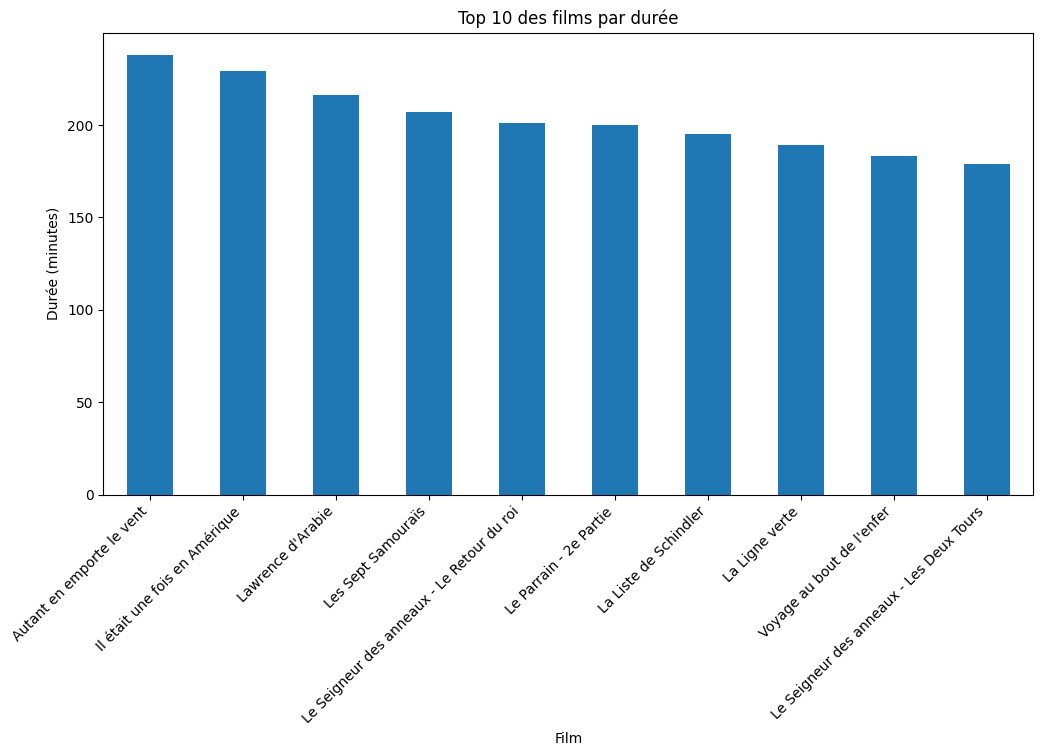

In [82]:
top10 = df.sort_values(by='Durée', ascending=False).head(10)

gr = top10.plot(x='title',y='Durée',kind='bar',figsize=(12, 6),legend=False)

gr.set_title('Top 10 des films par durée')
gr.set_xlabel('Film')
gr.set_ylabel('Durée (minutes)')
plt.xticks(rotation=45, ha='right')

In [83]:
moyenne_durée = df['Durée'].sum() / len(df)
moyenne_durée

np.float64(128.76729559748426)

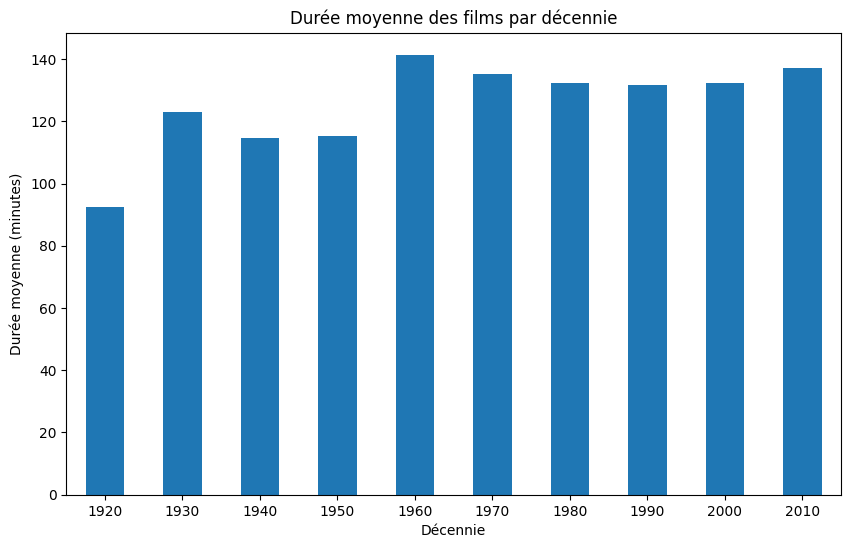

,id,title,year,genre,duration,director,rating,rating_count,link,budget,date_scraping,Durée,Decade
0,1,Les Évadés,1994,Drame,2h 22min,Frank Darabont,8.1,65372,https://www.senscritique.com/film/les_evades/4...,None,2026-01-21T15:20:27.096767,142,1990
1,2,Le Parrain,1972,"Policier, Drame",2h 55min,Francis Ford Coppola,8.5,75543,https://www.senscritique.com/film/le_parrain/4...,None,2026-01-21T15:20:27.347525,175,1970
2,3,Le Parrain - 2e Partie,1974,"Gangster, Drame",3h 20min,Francis Ford Coppola,8.3,44596,https://www.senscritique.com/film/le_parrain_2...,None,2026-01-21T15:20:27.547934,200,1970
3,4,Pulp Fiction,1994,"Gangster, Policier, Comédie",2h 34min,Quentin Tarantino,8.3,238205,https://www.senscritique.com/film/pulp_fiction...,None,2026-01-21T15:20:27.753848,154,1990
4,5,"Le Bon, la Brute et le Truand",1966,"Western, Aventure",2h 59min,Sergio Leone,8.5,58684,https://www.senscritique.com/film/le_bon_la_br...,None,2026-01-21T15:20:27.948964,179,1960
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,155,Dans ses yeux,2009,"Drame, Policier",2h 9min,Juan José Campanella,7.5,7137,https://www.senscritique.com/film/dans_ses_yeu...,None,2026-01-21T15:22:51.784002,129,2000
155,156,Autant en emporte le vent,1939,"Drame, Historique, Romance, Guerre",3h 58min,Victor Fleming,7.1,14978,https://www.senscritique.com/film/autant_en_em...,None,2026-01-21T15:22:51.992064,238,1930
156,157,Annie Hall,1977,"Romance, Comédie dramatique",1h 33min,Woody Allen,7.4,15883,https://www.senscritique.com/film/annie_hall/4...,None,2026-01-21T15:22:52.185072,93,1970
157,158,Les Raisins de la colère,1940,"Drame, Historique, Road movie",2h 9min,John Ford,7.9,6379,https://www.senscritique.com/film/les_raisins_...,None,2026-01-21T15:22:52.391842,129,1940


In [84]:
df['Decade'] = (df['year'] // 10) * 10

duree_moyenne_par_decennie = (df.groupby('Decade')['Durée'].mean() .reset_index().rename(columns={'Durée': 'durée_moyenne'}))


gr = duree_moyenne_par_decennie.plot(
    x='Decade',
    y='durée_moyenne',
    figsize=(10, 6),
    kind='bar',
    legend=False,
)

gr.set_title('Durée moyenne des films par décennie')
gr.set_xlabel('Décennie')
gr.set_ylabel('Durée moyenne (minutes)')
plt.xticks(rotation=0)
plt.show()
df

**Analyse :** la durée des films augmente ostensiblement au cours des décennies. Cela s'explique par l'augmentation des budgets alloués au cinéma et les technologies plus avancées, permettant de tourner plus longtemps sans interruption.

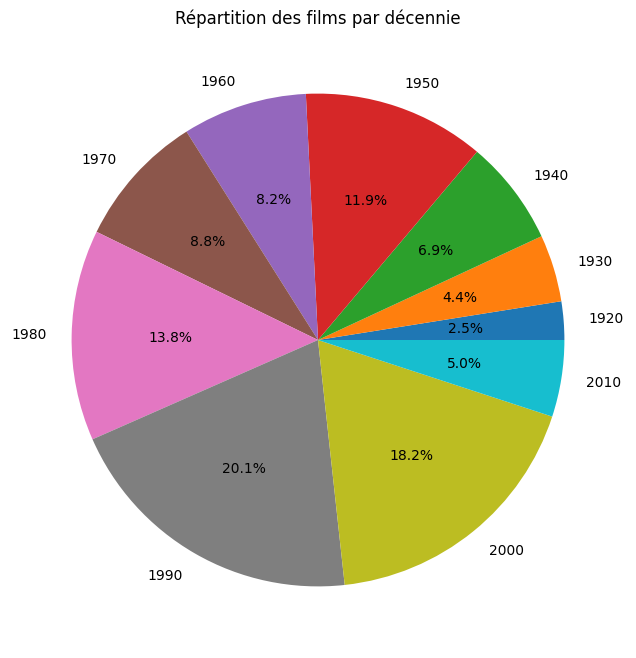

In [90]:


films_par_decennie = df['Decade'].value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.pie(
    films_par_decennie.values,
    labels=films_par_decennie.index.astype(str),  # convertir en string pour affichage
    autopct='%1.1f%%')

plt.title('Répartition des films par décennie')
plt.show()

In [86]:
df['genre'].value_counts()



genre
Drame                                 10
Policier, Drame, Thriller              6
Film noir                              5
Drame, Guerre                          5
Policier, Drame                        4
                                      ..
Drame, Sport                           1
Drame, Historique, Romance, Guerre     1
Romance, Comédie dramatique            1
Drame, Historique, Road movie          1
Animation, Fantastique                 1
Name: count, Length: 105, dtype: int64

genre
Drame                 86
Thriller              36
Aventure              32
Policier              24
Guerre                23
Action                20
Science-fiction       19
Comédie               15
Gangster              14
Biopic                13
Romance               12
Fantastique           10
Film noir             10
Historique             9
Western                9
Comédie dramatique     9
Épouvante-Horreur      9
Animation              9
Muet                   6
Fantasy                5
Arts martiaux          4
Comédie romantique     3
Road movie             3
Sport                  2
Comédie musicale       2
Péplum                 1
Sketches               1
Name: count, dtype: int64


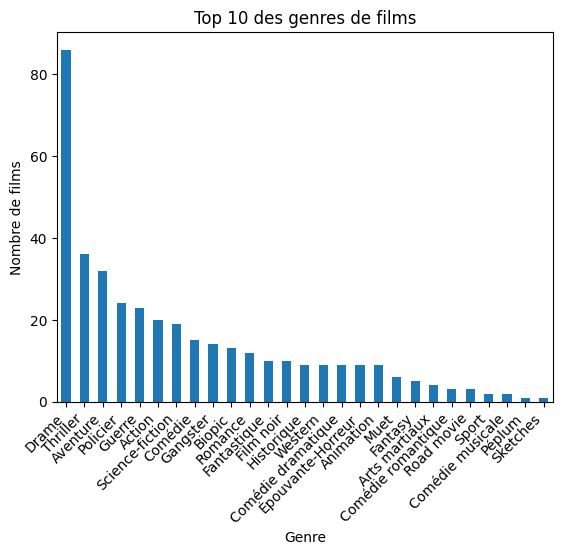

In [87]:
df_genres = df.dropna(subset=['genre'])
all_genres = df_genres['genre'].str.split(',').explode()
all_genres = all_genres.str.strip()
genre_counts = all_genres.value_counts()
print(genre_counts)
top10_genres = genre_counts.head(100)
gr = top10_genres.plot(kind='bar')

gr.set_title('Top 10 des genres de films')
gr.set_xlabel('Genre')
gr.set_ylabel('Nombre de films')
plt.xticks(rotation=45, ha='right')
plt.show()

genre
Drame                 54.088050
Thriller              22.641509
Aventure              20.125786
Policier              15.094340
Guerre                14.465409
Action                12.578616
Science-fiction       11.949686
Comédie                9.433962
Gangster               8.805031
Biopic                 8.176101
Romance                7.547170
Fantastique            6.289308
Film noir              6.289308
Historique             5.660377
Western                5.660377
Comédie dramatique     5.660377
Épouvante-Horreur      5.660377
Animation              5.660377
Muet                   3.773585
Fantasy                3.144654
Arts martiaux          2.515723
Comédie romantique     1.886792
Road movie             1.886792
Sport                  1.257862
Comédie musicale       1.257862
Péplum                 0.628931
Sketches               0.628931
Name: count, dtype: float64


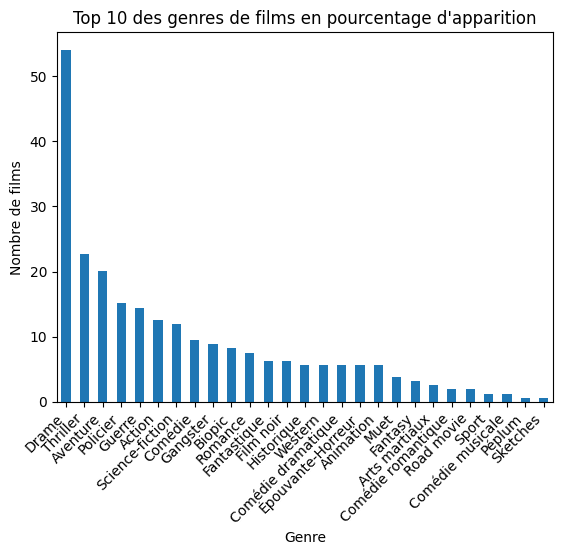

In [88]:
df_genres = df.dropna(subset=['genre'])
all_genres = df_genres['genre'].str.split(',').explode()
all_genres = all_genres.str.strip()
genre_counts = all_genres.value_counts()/len(df)*100
print(genre_counts)
top10_genres = genre_counts.head(100)
gr = top10_genres.plot(kind='bar')

gr.set_title('Top 10 des genres de films en pourcentage d\'apparition')
gr.set_xlabel('Genre')
gr.set_ylabel('Nombre de films')
plt.xticks(rotation=45, ha='right')
plt.show()

**Analyse :** Les drames apparaissent clairement comme le genre le plus populaire, avec 54% du top.

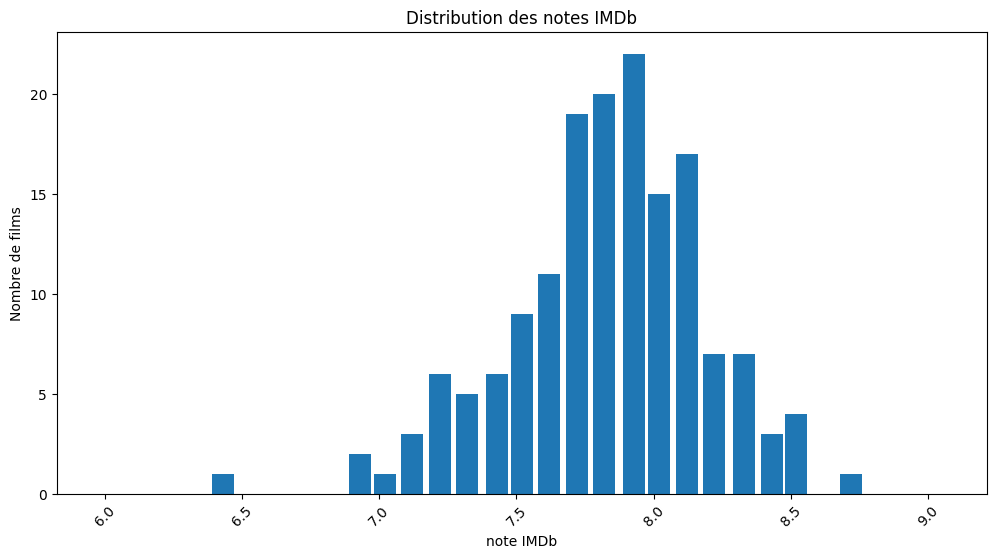

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

min_rating = df['rating'].min()
max_rating = df['rating'].max()

tranche = np.arange(np.floor(min_rating), np.ceil(max_rating) + 0.05, 0.05)

df['rating_bin'] = pd.cut(df['rating'], bins=tranche)

rating_counts = df['rating_bin'].value_counts().sort_index()

labels = [round(interval.left + 0.025, 2) for interval in rating_counts.index]

plt.figure(figsize=(12, 6))
plt.bar(labels, rating_counts.values, width=0.08)

plt.title('Distribution des notes IMDb')
plt.xlabel('note IMDb')
plt.ylabel('Nombre de films')
plt.xticks(rotation=45)
plt.show()


**Analyse :** La distribution des valeurs ressemble à une distribution normale centrée autour de 7.9.
